In [1]:
import pandas as pd
import os
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM, AutoModelForMaskedLM, AutoModelForSeq2SeqLM, AutoModelForSequenceClassification
from tqdm.auto import tqdm
import evaluate
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_scheduler
import json
from sklearn.model_selection import train_test_split

from TextDataset import TextDataset
from transformers import BertForSequenceClassification, BertConfig, BertTokenizer

from matplotlib import pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

mps


In [3]:
# Create a config with the desired settings
config = BertConfig.from_pretrained('bert-base-uncased', num_labels=2)

# Load the model with the custom config
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', config=config)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

new_tokens = ['\n', '(.)', '(..)', '(...)', 'xxx']
tokenizer.add_tokens(new_tokens)
model.resize_token_embeddings(len(tokenizer))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/alan/anaconda3/envs/capstone/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Embedding(30527, 768, padding_idx=0)

In [4]:
def calculate_accuracy(model, test):
    if test == 86:
        test = pd.read_csv("../data/test_complete_v1_86.csv")
        lines_test = test["line"].to_list()
        labels_test = test["label"].to_list()  
    elif test == 149:
        test = pd.read_csv("../data/test_complete_v1_149.csv")
        lines_test = test["line"].to_list()
        labels_test = test["label"].to_list()
    test_dataset = TextDataset(lines_test, labels_test, tokenizer)
    test_dataloader = DataLoader(test_dataset, batch_size=16)
    # Load the metrics you want to compute
    accuracy_metric = evaluate.load("accuracy")
    # Initialize lists to store all predictions and references
    all_predictions = []
    all_references = []
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    for batch in test_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        # Move predictions and references to CPU and convert to numpy arrays
        predictions_cpu = predictions.cpu().numpy()
        references_cpu = batch["labels"].cpu().numpy()

        # Store predictions and references
        all_predictions.extend(predictions_cpu)
        all_references.extend(references_cpu)

    # Compute all metrics at once using the full predictions
    accuracy = accuracy_metric.compute(predictions=all_predictions, references=all_references)
    return accuracy["accuracy"]


In [16]:
model.load_state_dict(torch.load("models.nosync/true_400_49epoch_81acc_0.01loss.pt"))
true_86 = calculate_accuracy(model, 86)
true_149 = calculate_accuracy(model, 149)

In [30]:
majority_guess = (149-43)/149

In [5]:
result_86_df = pd.DataFrame(index=[800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400], columns=["v1", "v3", "v4"])
result_149_df = pd.DataFrame(index=[800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400], columns=["v1", "v3", "v4"])

In [6]:
model_files = []
for filename in os.listdir('models.nosync/'):
    model_files.append(filename)
model_files.sort()
model_files = model_files[3:]

In [8]:
for i in tqdm(model_files):
    version = i.split('_')[0]
    size = int(i.split('_')[1])
    model.load_state_dict(torch.load("models.nosync/{0}".format(i)))
    result_86_df.at[size, version] = calculate_accuracy(model, 86)
    result_149_df.at[size, version] = calculate_accuracy(model, 149)
    

  0%|          | 0/21 [00:00<?, ?it/s]

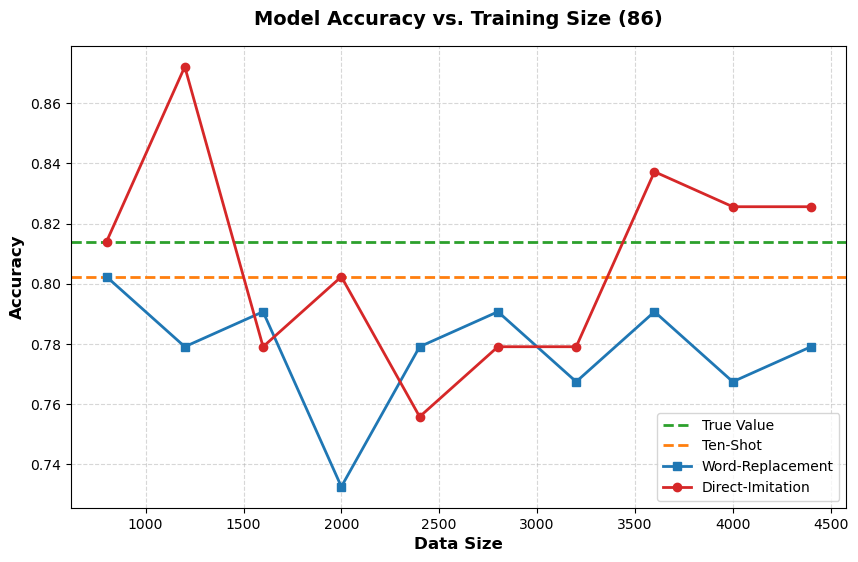

In [25]:
import matplotlib.pyplot as plt

# Assuming 'result_86_df' is your DataFrame and 'true_86' is the single value for 'True'

plt.figure(figsize=(10, 6))  # Set figure size and high resolution

# Add horizontal line for 'True'
plt.axhline(y=true_86, color='tab:green', linestyle='--', linewidth=2, 
            label='True Value')

# Plot lines for v3 and v4 with the specified colors and styles

plt.axhline(y=result_86_df.loc[4400, "v1"], color='tab:orange', linestyle='--', linewidth=2, 
            label='Ten-Shot')

plt.plot(result_86_df.index, result_86_df['v4'], label='Word-Replacement', 
         color='tab:blue', marker='s', linewidth=2)


plt.plot(result_86_df.index, result_86_df['v3'], label='Direct-Imitation', 
         color='tab:red', marker='o', linewidth=2)

# Customize labels, title, and legend
plt.xlabel('Data Size', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Accuracy vs. Training Size (86)', fontsize=14, fontweight='bold', pad=15)

# Adjust the legend alignment
plt.legend(loc='lower right', fontsize=10, frameon=True)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)

# Improve tick labels
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Save the plot with a transparent background
# plt.tight_layout()
# plt.savefig("accuracy_vs_data_size.png", transparent=True, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

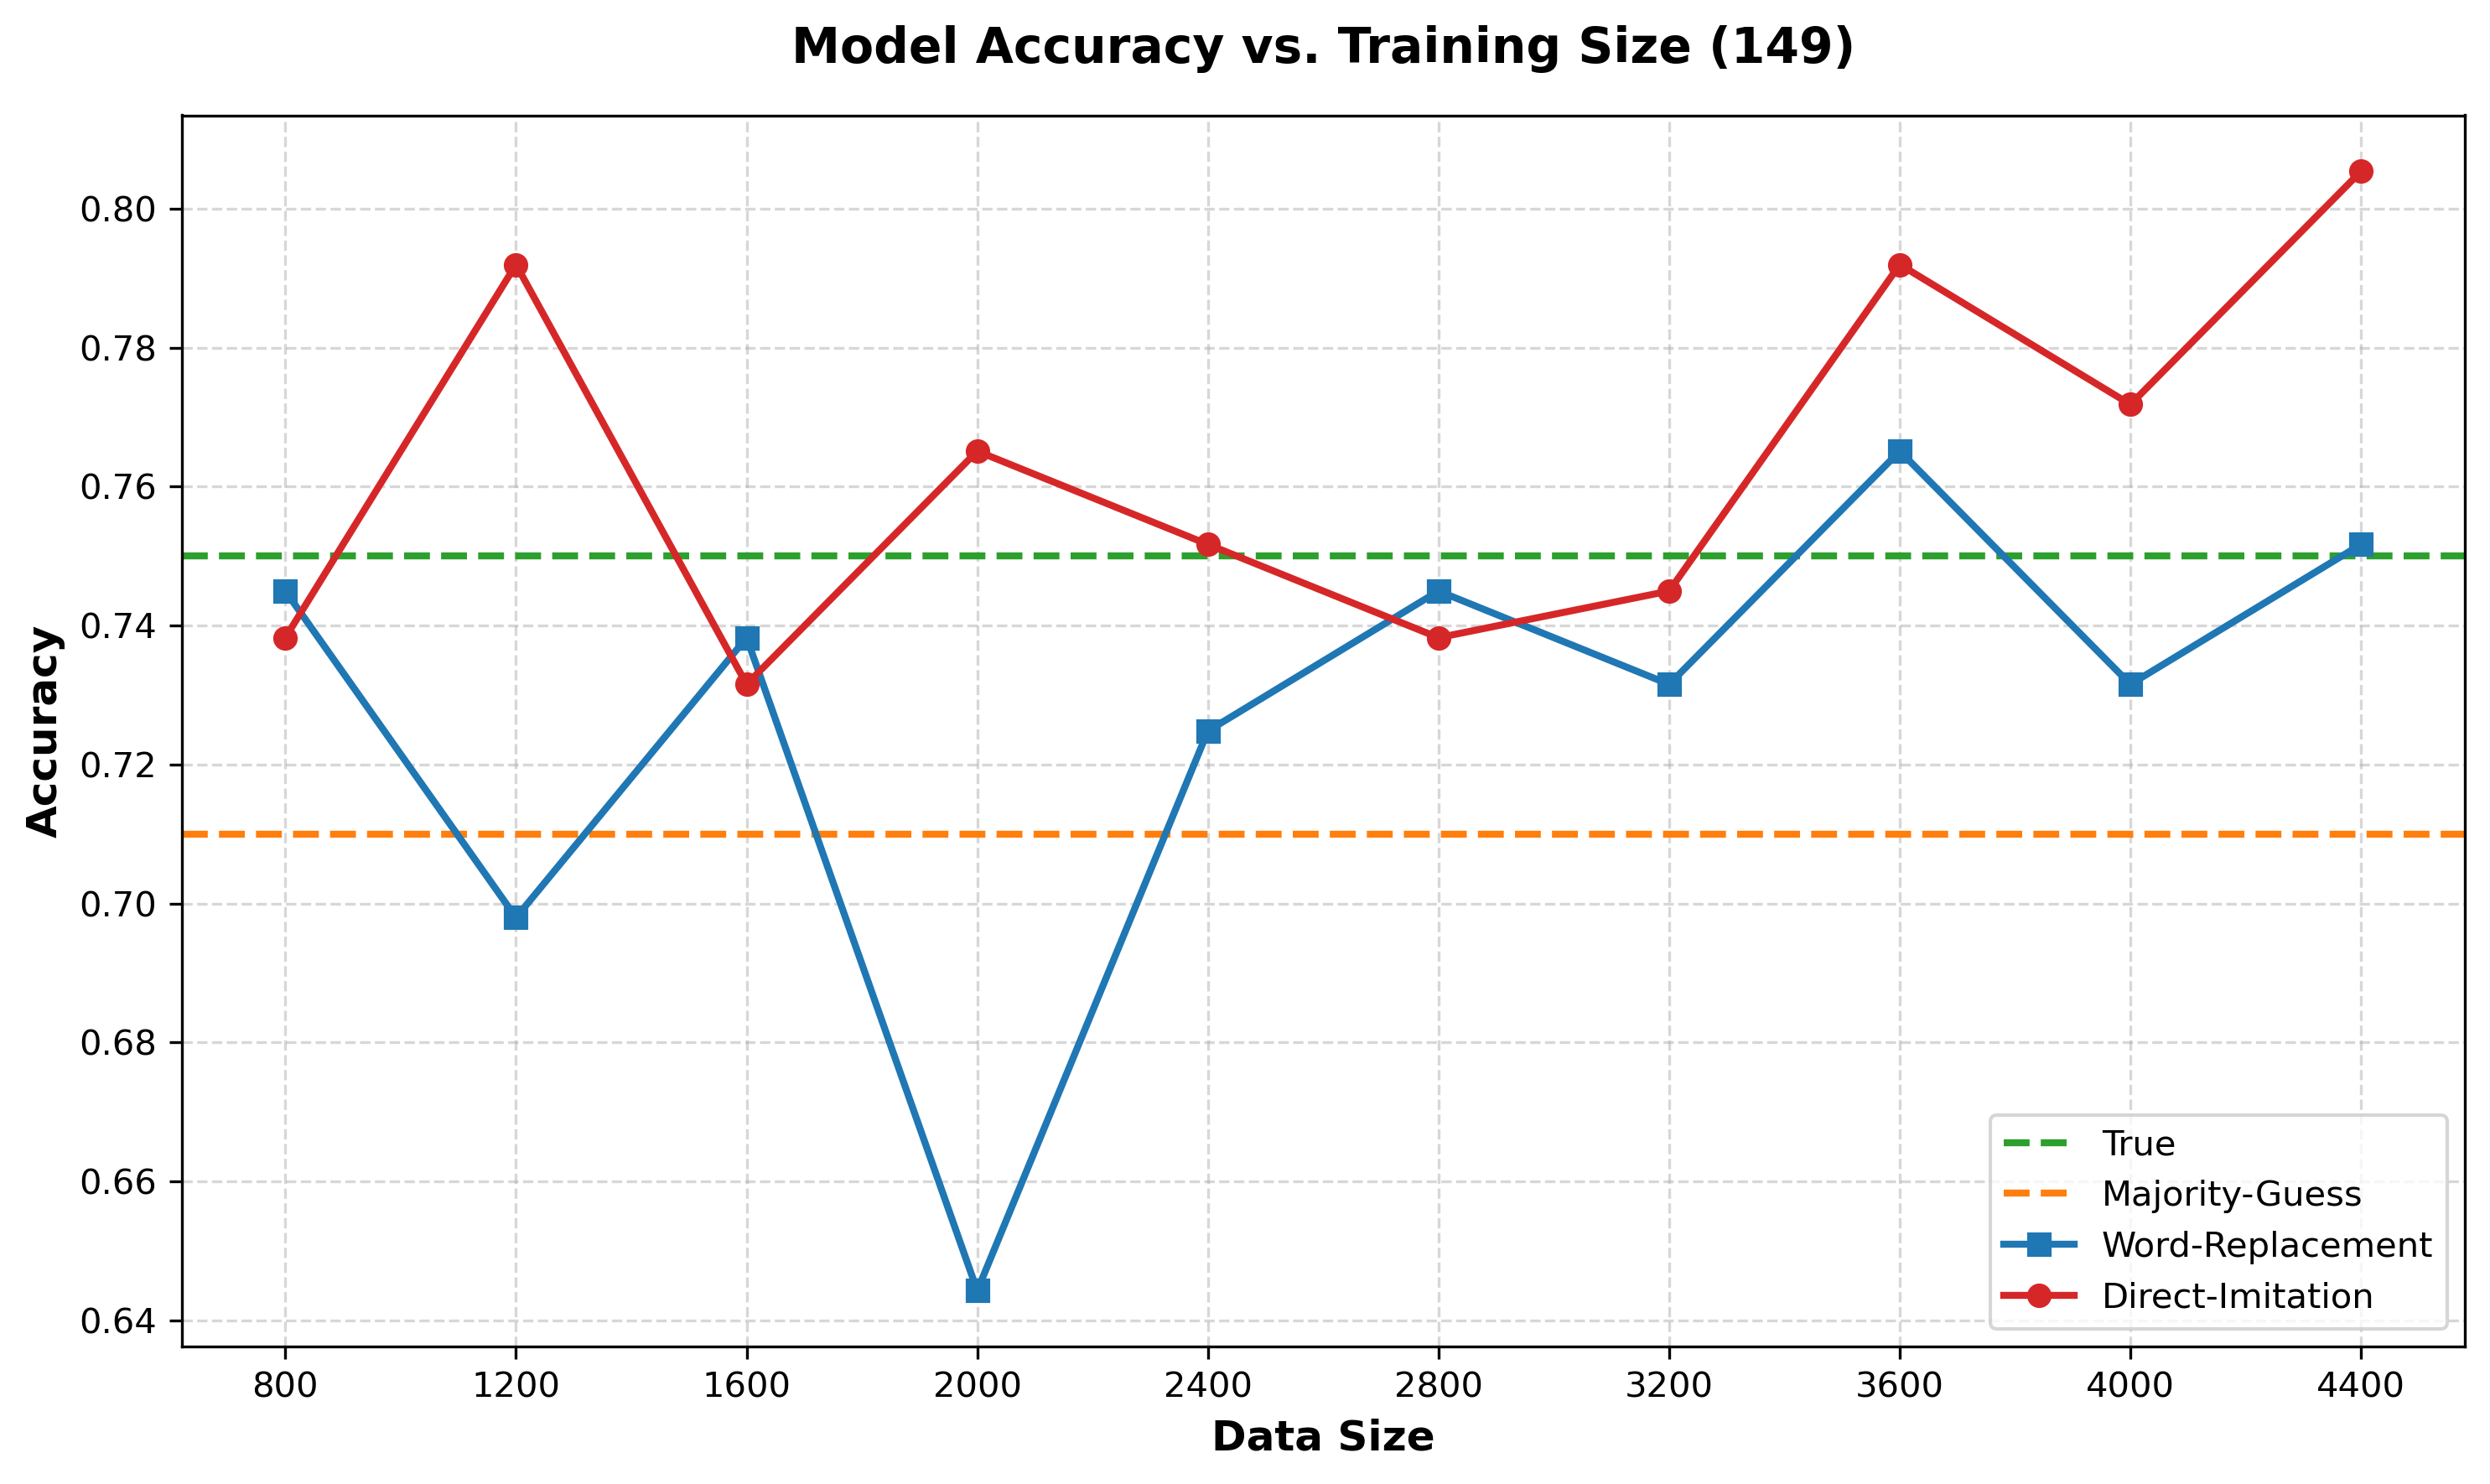

In [39]:
import matplotlib.pyplot as plt

# Assuming 'result_149_df' is your DataFrame and 'true_149' is the true value
true_149 = 0.75  # Replace this with the actual value
majority_guess = 0.71  # Replace this with the majority-guess value

plt.figure(figsize=(10, 6), dpi=300)

plt.axhline(y=true_149, color='tab:green', linestyle='--', linewidth=2, label='True')
plt.axhline(y=majority_guess, color='tab:orange', linestyle='--', linewidth=2, label='Majority-Guess')
plt.plot(result_149_df.index, result_149_df['v4'], label='Word-Replacement', 
         color='tab:blue', marker='s', linewidth=2)
plt.plot(result_149_df.index, result_149_df['v3'], label='Direct-Imitation', 
         color='tab:red', marker='o', linewidth=2)



# Adjust X-axis ticks to match 800, 1200, 1600, ...
custom_ticks = [800, 1200, 1600, 2000, 2400, 2800, 3200, 3600, 4000, 4400]
plt.xticks(custom_ticks, fontsize=10)

# Customize labels and legend
plt.xlabel('Data Size', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Model Accuracy vs. Training Size (149)', fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='lower right', fontsize=10)

# Grid and formatting
plt.grid(True, linestyle='--', alpha=0.5)

# Save the plot with transparent background
plt.tight_layout()
plt.savefig("../plots/accuracy_vs_data_size.png", transparent=True, dpi=1080, bbox_inches='tight')

# Show the plot
plt.show()

In [34]:
true_149

0.7516778523489933